In [1]:
import pandas as pd
import hvplot.pandas
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
ICE_USDCNY_1D = Path("Resources/ICE_USDCNY_1D.csv")

In [3]:
usdcny_1D = pd.read_csv(
    ICE_USDCNY_1D,
    index_col="time",
    parse_dates=True,
)
usdcny_1D = usdcny_1D.dropna()
print('Shape of data', usdcny_1D.shape)
usdcny_1D.head()

Shape of data (10919, 5)


,open,high,low,close,Volume
time,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [4]:
usdcny_1D = usdcny_1D.rename_axis("Date")
usdcny_1D.head()

,open,high,low,close,Volume
Date,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [5]:
usdcny_1D = usdcny_1D[["close"]]

usdcny_1D.tail()

,close
Date,
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795
2024-03-13,7.1856
2024-03-14,7.1927


<Axes: xlabel='Date'>

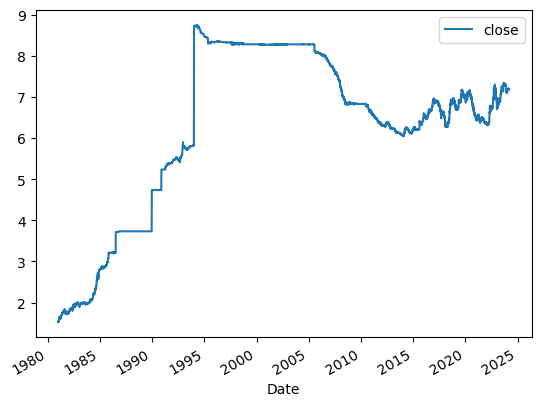

In [6]:
usdcny_1D.plot()

In [7]:
# Post-currency devaluation August 2015

start_date = '2015-08-01'
end_date = '2024-03-14'

# Boolean indexing to select rows within the specified date range
usdcny_post2015 = usdcny_1D[(usdcny_1D.index >= start_date) & (usdcny_1D.index <= end_date)]
usdcny_post2015

,close
Date,
2015-08-03,6.2087
2015-08-04,6.2085
2015-08-05,6.2095
2015-08-06,6.2095
2015-08-07,6.2085
...,...
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795


In [8]:
usdcny_post2015 = usdcny_post2015.asfreq('d', method='ffill')
# 'ffill' is crucial because it will fill in the missing data using the previous avaiable data.
# If not filled, those dates will be dropped and we'll have problems later
# usdcny_post2015 = usdcny_post2015.dropna()
usdcny_post2015.isnull().sum()

close    0
dtype: int64

In [9]:
#usdcny_post2015 = usdcny_post2015.asfreq('d')
usdcny_post2015.index

DatetimeIndex(['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12',
               ...
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', name='Date', length=3147, freq='D')

<Axes: xlabel='Date'>

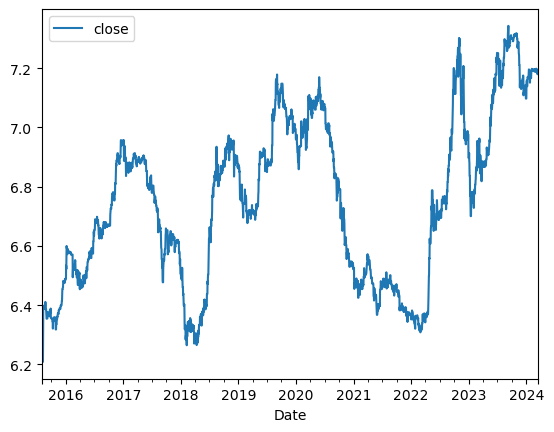

In [10]:
usdcny_post2015.plot()

In [11]:
# Function that checks for stationarity
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [12]:
check_stationarity(usdcny_post2015)

The series is NOT stationary


## Figure out order for ARIMA Model

In [13]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(
    usdcny_post2015,
    seasonal=True,
    trace=True,
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-17428.090, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17431.518, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17431.663, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17431.760, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17432.176, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17428.190, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.452 seconds


In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
usdcny_post2015.index

DatetimeIndex(['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12',
               ...
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', name='Date', length=3147, freq='D')

## Split Data into Training and Testing

In [16]:
print(usdcny_post2015.shape)
train = usdcny_post2015.iloc[:-90]
test = usdcny_post2015.iloc[-90:]
print(train.shape, test.shape)

(3147, 1)
(3057, 1) (90, 1)


## Fit the model to the training data

In [19]:
model = ARIMA(usdcny_post2015, order=(2,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 3147
Model:                 ARIMA(2, 1, 2)   Log Likelihood                8719.288
Date:                Sun, 24 Mar 2024   AIC                         -17428.577
Time:                        22:04:01   BIC                         -17398.307
Sample:                    08-03-2015   HQIC                        -17417.715
                         - 03-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2689      0.944      0.285      0.776      -1.581       2.119
ar.L2         -0.2310      0.536     -0.431      0.667      -1.282       0.820
ma.L1         -0.2958      0.946     -0.313      0.754      -2.149       1.557
ma.L2          0.2152      0.560      0.384      0.701      -0.883       1.313
sigma2         0.0002   2.61e-06     87.898      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8854.66
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Observe the Model Performance

In [20]:
predictions = model.predict()

In [21]:
predictions_df = pd.DataFrame(predictions)

<Axes: xlabel='Date'>

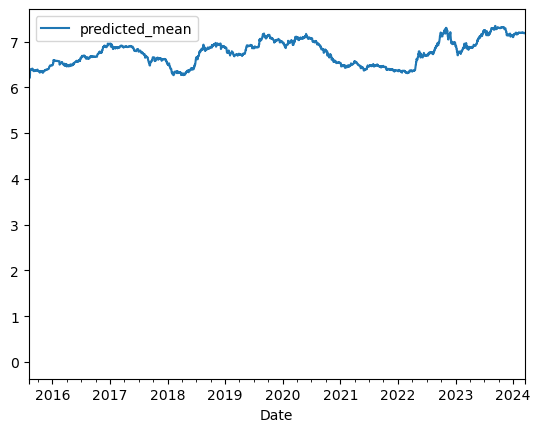

In [22]:
predictions_df.plot()

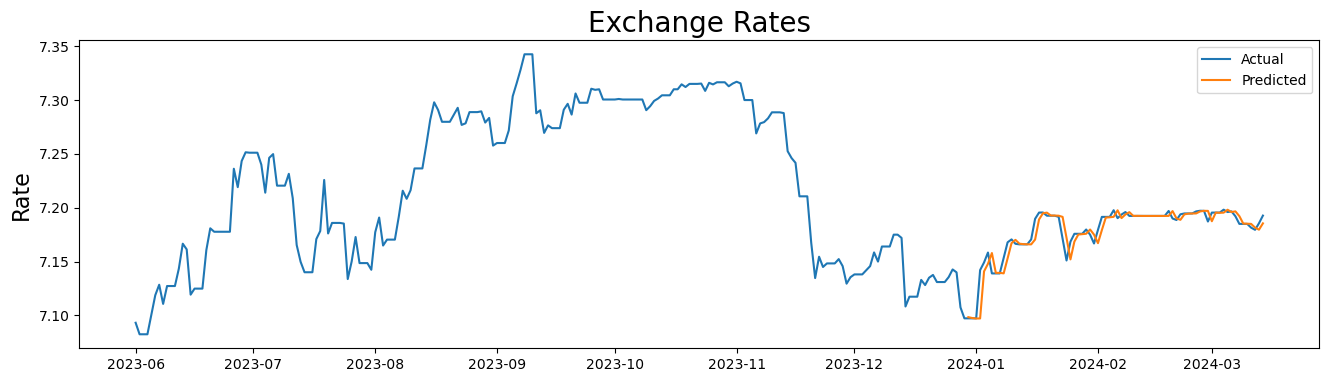

In [26]:
desired_start_date= '2023-06-01'
df_subset_model = predictions_df[predictions_df.index >= desired_start_date]
df_subset_actual = usdcny_post2015[usdcny_post2015.index >= desired_start_date]


plt.figure(figsize=(16,4))
plt.plot(df_subset_actual, label="Actual")
plt.plot(df_subset_model['2023-12-30':], label="Predicted")
plt.title('Exchange Rates', fontsize=20)
plt.ylabel('Rate', fontsize=16)
plt.legend()

In [22]:
test_predict = model.predict(test.index[0], test.index[-1], dynamic = True)
print(test_predict)

2023-12-16    7.117867
2023-12-17    7.117462
2023-12-18    7.117223
2023-12-19    7.117236
2023-12-20    7.117294
                ...   
2024-03-10    7.117298
2024-03-11    7.117298
2024-03-12    7.117298
2024-03-13    7.117298
2024-03-14    7.117298
Freq: D, Name: predicted_mean, Length: 90, dtype: float64
